# Analysing response time of the Nginx server

Nginx was configured with the following logging format:

```
log_format time_request '[$time_local] "$request" $status $body_bytes_sent $htt$
    '$request_time';
```

Which logs the time it takes for the response to be generated. The code below parses the log and builds histograms of the response times for the posting itself and for generating the dashboard.

In [11]:
import re
from pandas import DataFrame as df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',  figsize=(10, 5))

In [2]:
with open('privalytics_times.log', 'r') as f:
    log_data = f.read()
log_data = log_data.split('\n')

In [3]:
log_data[22]

'[26/Feb/2019:05:58:52 +0000] "GET /static/privalytics/vendor/daterangepicker/daterangepicker.css HTTP/1.1" 304 0 - "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65.0) Gecko/20100101 Firefox/65.0" 0.000'

In [4]:
lineformat = re.compile(
            r"""\[(?P<dateandtime>\d{2}\/[a-z]{3}\/\d{4}:\d{2}:\d{2}:\d{2} (\+|\-)\d{4})\] ["](?P<method>.+) (?P<url>.+)(http\/1\.1\") (?P<statuscode>\d{3}) (?P<bytessent>\d+) - (["](?P<useragent>.+)["]) (?P<response_time>\d.\d+)""",
            re.IGNORECASE)

In [5]:
datadict = []
for log_line in log_data:
    info = re.search(lineformat, log_line)
    if info:
        datadict.append(info.groupdict()) 

The loop above ignores any case in which the regular expression fails to find the values. It could be improved, to warn about the number of lines missed, etc. but it seems to work OK

## Pandas

Even if I am not a fan of Pandas, it is very useful to organize table-like data such as the logs from Nginx.

First we need to convert the columns to the appropriate data tipes, including the dateandtime column

In [6]:
data = df.from_dict(datadict)
data['response_time'] = data['response_time'].astype(np.float16)
data['statuscode'] = data['statuscode'].astype(np.int16)
data['bytessent'] = data['bytessent'].astype(np.int16)
data['dateandtime'] = pd.to_datetime(data['dateandtime'], format='%d/%b/%Y:%H:%M:%S %z')

In [7]:
data.head()

,bytessent,dateandtime,method,response_time,statuscode,url,useragent
0,3388,2019-02-26 05:57:10+00:00,GET,0.018997,200,/,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65....
1,989,2019-02-26 05:57:10+00:00,GET,0.000000,200,/static/privalytics/css/pricing.css,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65....
2,204,2019-02-26 05:57:10+00:00,GET,0.000000,200,/static/privalytics/css/showcase.css,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65....
3,5712,2019-02-26 05:57:10+00:00,GET,0.000000,200,/static/privalytics/img/analytics.png,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65....
4,6691,2019-02-26 05:57:10+00:00,GET,0.000000,200,/static/privalytics/img/user.png,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65....


# API Tracker

First, let's see what response times we get for the API endpoint.

In [8]:
api_tracker = data[data['url'].str.startswith('/api/tracker')]

In [9]:
t = api_tracker[(api_tracker['method'] == 'POST') & (api_tracker['statuscode']==200)]['response_time']*1000
t.describe()

count    4243.000000
mean       36.861778
std        69.238701
min        16.998291
25%        20.996094
50%        22.003174
75%        26.000977
max      2626.953125
Name: response_time, dtype: float64

Text(0.5,1,'Response time for tracker posts to endpoint /api/tracker')

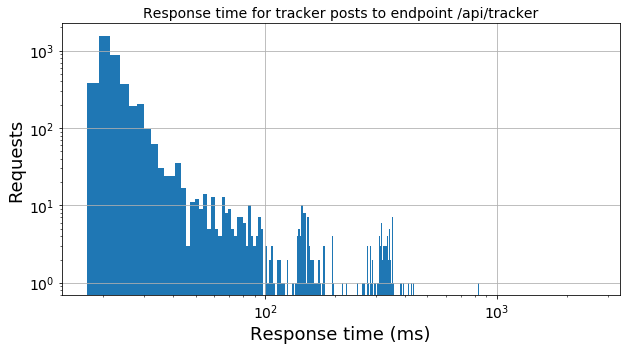

In [12]:
f = t.hist(bins=1200, log=True)
# plt.xlim(0, 100)
plt.xscale('log')
plt.tick_params(labelsize=14)
plt.xlabel('Response time (ms)', size=18)
plt.ylabel('Requests', size=18)
plt.title('Response time for tracker posts to endpoint /api/tracker', size=14)

Pay attention to the log-log scale. Response times are Below 30ms in 75% of the cases. Also, note that we are looking only at valid requests (status 200)

We can also look at the non 200 response codes:

In [13]:
t = api_tracker[(api_tracker['method'] == 'POST') & (api_tracker['statuscode']!=200)]['response_time']*1000
t.describe()

count    179.000000
mean      22.615993
std       57.311069
min        0.000000
25%        4.001617
50%        6.000519
75%        9.502411
max      367.919922
Name: response_time, dtype: float64

Text(0.5,1,'Response time for tracker posts to endpoint /api/tracker')

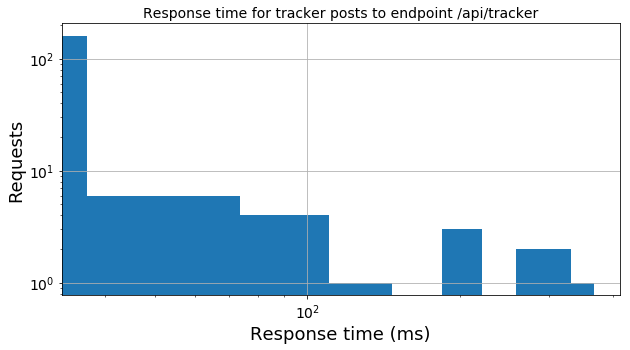

In [14]:
f = t.hist(bins=10, log=True)
# plt.xlim(0, 100)
plt.xscale('log')
plt.tick_params(labelsize=14)
plt.xlabel('Response time (ms)', size=18)
plt.ylabel('Requests', size=18)
plt.title('Response time for tracker posts to endpoint /api/tracker', size=14)

# Dashboard

Generating the dashboard is much more expensive, since the database queries are much more complex.

In [15]:
ws_dashboard = data[data['url'].str.startswith('/ws')]

In [16]:
t = ws_dashboard[ws_dashboard['method'] == 'GET']['response_time']*1000
t.describe()

count     160.000000
mean      785.873657
std       607.873657
min         0.000000
25%       360.839844
50%       798.828125
75%      1206.054688
max      4042.968750
Name: response_time, dtype: float64

Text(0.5,1,'Response time for dashboard at endpoint /ws')

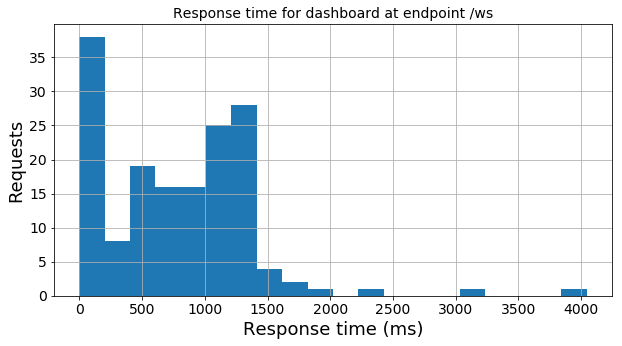

In [17]:
t.hist(bins=20)
# plt.xlim(0, 100)
plt.tick_params(labelsize=14)
plt.xlabel('Response time (ms)', size=18)
plt.ylabel('Requests', size=18)
plt.title('Response time for dashboard at endpoint /ws', size=14)

Generating the dashboard takes around 1 second in most cases. This can be improved with caching and some database optimizations, such as pre-compiling statistics instead of generating them every time the page is requested. It is also important to see what happens when user select ranges of dates:

In [18]:
t = ws_dashboard[ws_dashboard['method'] == 'POST']['response_time']*1000
t.describe()

count       4.000000
mean      730.590820
std       517.140991
min        62.011719
25%       453.491211
50%       847.167969
75%      1124.267578
max      1166.015625
Name: response_time, dtype: float64

Text(0.5,1,'Response time for dashboard at endpoint /ws')

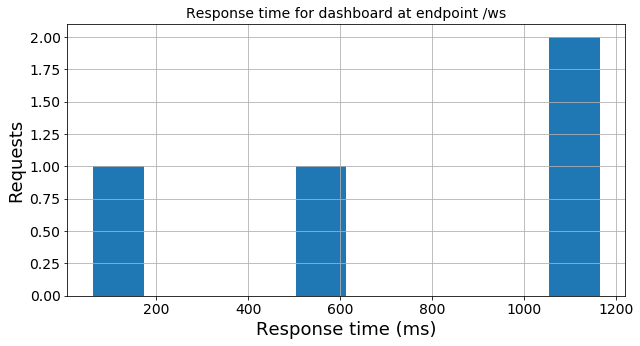

In [19]:
t.hist()
# plt.xlim(0, 100)
plt.tick_params(labelsize=14)
plt.xlabel('Response time (ms)', size=18)
plt.ylabel('Requests', size=18)
plt.title('Response time for dashboard at endpoint /ws', size=14)

Text(0.5,1,'Response time for tracker at endpoint /api/tracker')

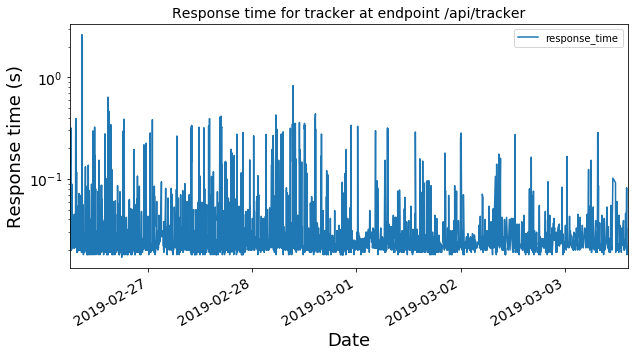

In [27]:
api_tracker[(api_tracker['method'] == 'POST') & (api_tracker['statuscode']==200)].plot('dateandtime', 'response_time')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.xlabel('Date', size=18)
plt.ylabel('Response time (s)', size=18)
plt.title('Response time for tracker at endpoint /api/tracker', size=14)